## Educational Recommender System
---

Dataset: [Open University Learning Analytics dataset](https://analyse.kmi.open.ac.uk/open_dataset)

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [67]:
%matplotlib inline

In [68]:
# load csv files into dataframes
assessments_df = pd.read_csv('data/assessments.csv')
courses_df = pd.read_csv('data/courses.csv')
student_assessment_df = pd.read_csv('data/studentAssessment.csv')
student_info_df = pd.read_csv('data/studentInfo.csv')
student_reg_df = pd.read_csv('data/studentRegistration.csv')
student_vle_df = pd.read_csv('data/studentVle.csv')
vle_df = pd.read_csv('data/vle.csv')

In [69]:
# divide the courses into B and J categories based on "code_presentation" because the structure of these 
# presentations is different

student_vle_df = pd.merge(student_vle_df, vle_df, on='id_site')

# * Pre processing Assessments
courses_B_df = courses_df[courses_df['code_presentation'].str.contains('B')]
courses_J_df = courses_df[courses_df['code_presentation'].str.contains('J')]

# * Pre processing Assessments
student_assessment_df = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
assessments_df.dropna(how='any', inplace=True)
assessments_df = pd.get_dummies(assessments_df, columns=["assessment_type"])
assessments_df["date"] = [int(date / 7) for date in assessments_df["date"]]
assessments_B_df = assessments_df[assessments_df['code_module'].isin(courses_B_df['code_module'])]
assessments_J_df = assessments_df[assessments_df['code_module'].isin(courses_J_df['code_module'])]

# * Pre processing VLE Dataset
# ! This gets rid of the records with no week_from and week_to values
# ! However, we are not sure if this is the right way to handle this
# * Maybe we can use the student VLE interactions to fill in the missing values
vle_df.dropna(how='any', inplace=True)
vle_df = pd.get_dummies(vle_df, columns=["activity_type"])
vle_B_df = vle_df[vle_df['code_module'].isin(courses_B_df['code_module'])]
vle_J_df = vle_df[vle_df['code_module'].isin(courses_J_df['code_module'])]

# * Pre processing Student Info Dataset
student_info_df.dropna(how='any', inplace=True)
student_info_df = pd.get_dummies(student_info_df, columns=["gender", "region", "highest_education", "imd_band", "age_band", "disability", "final_result"])
student_info_B_df = student_info_df[student_info_df['code_module'].isin(courses_B_df['code_module'])]
student_info_J_df = student_info_df[student_info_df['code_module'].isin(courses_J_df['code_module'])]

# student_vle_df["date"].unique()

In [70]:
def get_vle_interaction_by_site(id_site):
    """
    Returns the student vle interaction for a given site id
    """
    df = pd.DataFrame()
    df = student_vle_df[student_vle_df['id_site'] == id_site]
    return df

def get_vle_interaction_by_student(student_id):
    """
    Returns the student vle interaction for a given student id
    """
    return student_vle_df[student_vle_df['id_student'] == student_id]

def get_student_assessment_scores(student_id):
    """
    Returns the student assessment scores for a given student id
    """
    df = pd.DataFrame()
    df = student_assessment_df[student_assessment_df['id_student'] == student_id]
    return df

def get_unique_vle_sites():
    return student_vle_df['id_site'].unique()    

def calculate_euclidean_distance_student(student_id):
    """
    Returns the euclidean distance between the student and all other students
    """
    student = student_info_df[student_info_df['id_student'] == student_id]
    student = student.drop(columns=['id_student'])
    student = student.values
    students = student_info_df.drop(columns=['id_student', 'code_module', 'code_presentation'])
    students = students.values
    return np.linalg.norm(students - student, axis=1)



In [71]:
student_info_B_df.shape
# student_info_J_df.head()
# student_vle_df.head()
# vle_B_df.head()

(30757, 44)

### Data Exploration

We need to find trends in students' engagement with the VLE and their test scores (indication of proficiency in a topic).It would appear that  

Processing Students: 100%|██████████| 1000/1000 [00:30<00:00, 33.31it/s]


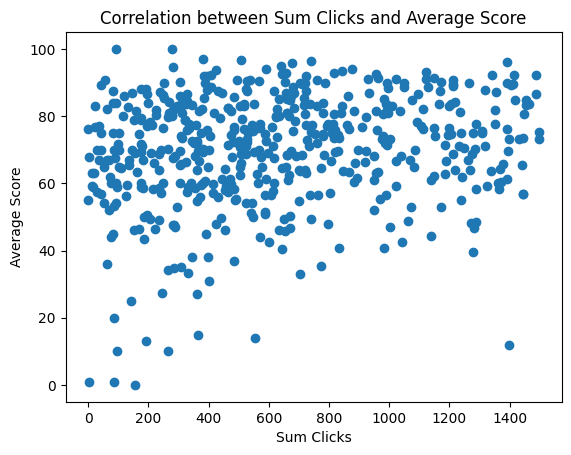

In [72]:
from tqdm import tqdm
# find a correlation between VLE Clicks and Student assesments

def get_clicks_for_id_site_by_student(id_site, student_vle_interaction):
    """
    Returns the number of clicks for a given site id
    """
    return student_vle_interaction[student_vle_interaction['id_site'] == id_site].sum()["sum_click"]

def corr_clicks_assessments():
    """
    Displays the correlation between VLE Clicks and Student assesments

    ! Caution: We are only analyzing the B presentations for now
    """
    clicks_assessment_scores_df = pd.DataFrame()
    
    for index, student in tqdm(student_info_B_df.sample(n=1000).iterrows(), total=1000, desc="Processing Students"):
        # print("Student ID: ", student["id_student"])
        assessment_scores = get_student_assessment_scores(student["id_student"])
        student_vle_interaction = get_vle_interaction_by_student(student["id_student"]) 
        assessment_scores = pd.merge(assessment_scores, assessments_B_df, on='id_assessment')

        sum_clicks_per_student = 0
        for id_site in student_vle_interaction["id_site"].unique():
            clicks = get_clicks_for_id_site_by_student(id_site, student_vle_interaction)
            sum_clicks_per_student += clicks
        
        average_score = assessment_scores["score"].mean()
        # print("Module:", student["code_module"], "Sum Clicks: ", sum_clicks_per_student, "Average Score: ", average_score)
        new_row = pd.DataFrame({"sum_clicks": [sum_clicks_per_student], "average_score": [average_score]})
        if (sum_clicks_per_student < 1500):
            clicks_assessment_scores_df = pd.concat([clicks_assessment_scores_df, new_row], ignore_index=True)

        # print(assessment_scores.head())
        # print(student_vle_interaction)
        # print(vle_interaction.groupby)

    # print(clicks_assessment_scores_df.head()) 
    plt.scatter(clicks_assessment_scores_df["sum_clicks"], clicks_assessment_scores_df["average_score"])
    plt.xlabel("Sum Clicks")
    plt.ylabel("Average Score")
    plt.title("Correlation between Sum Clicks and Average Score")
    plt.show()

corr_clicks_assessments()
# show_clicks_by_type()

### Clicks vs Type of Content

We needed to see if the sum_clicks differ drastically based on content type in the VLE. It would appear that it does. There seems to be steep difference in the sum_clicks on "oucontent" type vs something like "dataplus". OUContent appears to be content embedded within the Open University VLE itself and the abnormally large sum_clicks could be due to a tracking deficit in other activity types.  

activity_type
dataplus             2925
dualpane             6953
oucontent         5552414
ouwiki               1940
page                17076
questionnaire       41889
quiz                97391
repeatactivity          8
resource           105002
subpage            516244
url                106476
Name: sum_click, dtype: int64


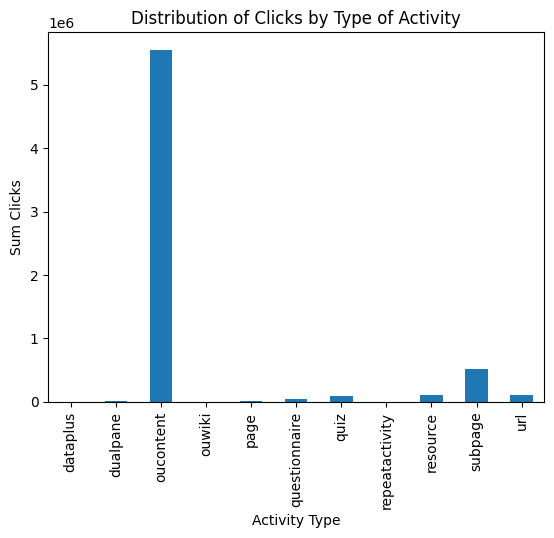

In [73]:
# Get distribution of clicks by type of activity

def show_clicks_by_type():
    """
    Displays the distribution of clicks by type of activity
    """
    merged_vle = pd.merge(student_vle_df, vle_df, on='id_site')
    clicks_by_type = merged_vle.groupby("activity_type")["sum_click"].sum()
    print(clicks_by_type)
    clicks_by_type.plot(kind='bar')
    plt.xlabel("Activity Type")
    plt.ylabel("Sum Clicks")
    plt.title("Distribution of Clicks by Type of Activity")
    plt.show()

    # TODO calculate how many of each type of resource is there

show_clicks_by_type()

In [104]:
from sklearn.linear_model import LinearRegression
import datetime
import numpy as np

# Get sucessful student ids
def get_student_assessment_trends(student_info_dataframe):
    """
    Returns the ids of successful students
    Currently the heuristic is to find students with a positive slope in their assessment scores
    The slope threshold currently is 0.05 because that is the 75th percentile of the slope distribution
    """
    # plot student assessment trends
    student_assessment_df_merged = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
    student_trend_df = pd.DataFrame()
    # print(student_assessment_df_merged.groupby('id_student')["score"].count())

    
    for index, student in tqdm(student_info_dataframe.iterrows(), total=student_info_dataframe.shape[0], desc="Processing Students"):
        student_scores = get_student_assessment_scores(student["id_student"])
        if (student_scores.empty):
            continue
        student_scores = student_scores.dropna(how='any', inplace=False)
        # print("Scores: ", student_scores)

        # calculate a linear regression line for the student scores
        x = student_scores["date"].values.reshape(-1, 1)
        y = student_scores["score"].values.reshape(-1, 1)
        if x.size == 0 or y.size == 0:
            continue
        model = LinearRegression()
        model.fit(x, y)
        m = model.coef_[0][0]
        b = model.intercept_[0]
        if x.size > 4:
            new_row = pd.DataFrame([{"slope": m, "intercept": b, "id_student": student["id_student"]}])
            student_trend_df = pd.concat([student_trend_df, new_row], ignore_index=True)

        # y_pred = m * x + b
        # plt.scatter(x, y, color='blue', label='Actual Scores')
        # plt.plot(x, y_pred, color='red', linewidth=2, label='Regression Line')
        # plt.xlabel('Date')
        # plt.ylabel('Score')
        # plt.legend()
        # plt.xticks(rotation=45)
        # plt.show()

        # print(f"Slope (m): {m}")
        # print(f"Intercept (b): {b}")        

        # print(student_scores)
    student_trend_df = pd.merge(student_trend_df, student_info_dataframe, on='id_student')
    return student_trend_df
    # return student_trend_df[student_trend_df["slope"] > student_trend_df["slope"].describe()["75%"]]

def get_successful_student_trends(student_info_dataframe):
    df = get_student_assessment_trends(student_info_dataframe)
    return df[df["slope"] > df["slope"].describe()["75%"]]

get_successful_student_trends(student_info_B_df) 


Processing Students: 100%|██████████| 30757/30757 [00:30<00:00, 1001.46it/s]


,slope,intercept,id_student,code_module,code_presentation,num_of_prev_attempts,studied_credits,gender_F,gender_M,region_East Anglian Region,...,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn
5,0.056122,81.826531,34229,BBB,2013B,2,120,True,False,False,...,False,False,True,False,True,False,False,False,True,False
7,0.076290,65.322998,34863,BBB,2013B,0,60,True,False,False,...,False,True,False,False,True,False,False,False,True,False
8,0.095927,72.294748,39655,BBB,2013B,0,120,True,False,False,...,False,True,False,False,True,False,True,False,False,False
10,0.129421,71.278037,52899,BBB,2013B,0,60,True,False,False,...,False,False,True,False,True,False,False,False,False,True
11,0.129421,71.278037,52899,BBB,2013J,1,90,True,False,False,...,False,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22908,0.172423,45.707112,2606765,GGG,2014J,0,30,True,False,False,...,False,True,False,False,True,False,False,False,True,False
22909,0.088261,71.903566,2620947,GGG,2014J,0,30,True,False,False,...,False,True,False,False,False,True,True,False,False,False
22910,0.099201,69.020496,2645731,GGG,2014J,0,30,True,False,True,...,False,False,True,False,True,False,True,False,False,False
22911,0.082625,60.766038,2648187,GGG,2014J,0,30,True,False,False,...,False,True,False,False,False,True,False,False,True,False


In [ ]:
def knn_recommender(id_student, selective_student_info_dataframe, k=5):
    """
    Returns the top k similar students to the given student id
    """
    # student_info_dataframe = 
    student = student_info_df[student_info_df['id_student'] == id_student]
    student = student.drop(columns=['id_student', 'code_module', 'code_presentation'])
    student = student.iloc[0]
    students = selective_student_info_dataframe.drop(columns=['id_student', 'code_module', 'code_presentation'])
    student = np.array(student, dtype=float)
    students = np.array(students, dtype=float)
    distances = np.linalg.norm(students - student, axis=1)
    indices = np.argsort(distances)[:k]
    return selective_student_info_dataframe.iloc[indices]

successful_students = get_successful_student_trends(student_info_df.sample(n=50))
successful_students.drop(columns=['slope', 'intercept'], inplace=True)
knn_recommender(student_info_df.sample(n=1).iloc[0]["id_student"], successful_students, k=5)


Processing Students: 100%|██████████| 50/50 [00:00<00:00, 1166.23it/s]

[[ 0. 90.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   1.  0.  0.  0.  1.]
 [ 0. 30.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
   1.  0.  0.  1.  0.]
 [ 0. 30.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.
   0.  0.  1.  0.  0.]
 [ 0. 60.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
   0.  0.  0.  0.  1.]
 [ 0. 60.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   1.  0.  0.  1.  0.]
 [ 0. 30.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  

,id_student,code_module,code_presentation,num_of_prev_attempts,studied_credits,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,...,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn
2,680145,CCC,2014J,0,90,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,True
14,322641,EEE,2014J,0,60,False,True,True,False,False,...,False,True,False,False,True,False,False,False,False,True
17,620215,EEE,2014B,0,60,False,True,False,False,False,...,False,True,False,False,False,True,False,False,True,False
4,588105,GGG,2013J,0,30,True,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
5,689839,GGG,2014J,0,30,False,True,False,False,False,...,False,False,True,False,True,False,False,True,False,False
